<a href="https://colab.research.google.com/github/SHudso30/customer-churn-prediction/blob/main/customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [6]:
# Unzip the file
!unzip archive.zip

#List files to see what we have
!ls

Archive:  archive.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  
archive.zip  sample_data  WA_Fn-UseC_-Telco-Customer-Churn.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# First look at the data
print("Dataset shapr:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shapr: (7043, 21)

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


DATA OVERVIEW

Column names and types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TARGET VARIABLE: Churn
/nChurn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


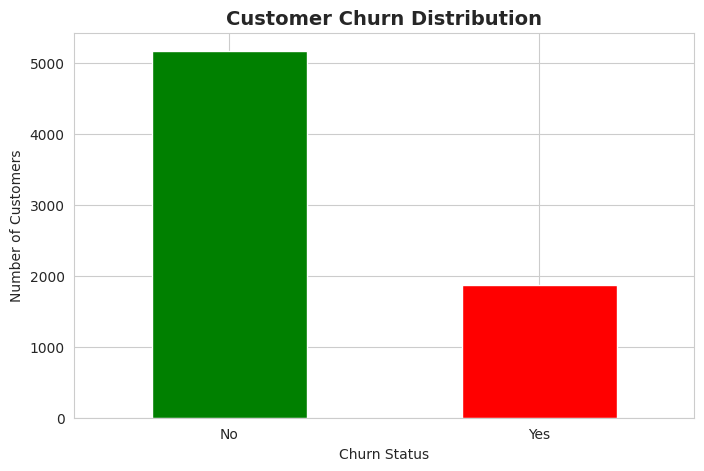

In [8]:
# Examine the data structure
print("=" * 50)
print("DATA OVERVIEW")
print("=" * 50)

print("\nColumn names and types:")
print(df.dtypes)

print("\n" + "=" * 50)
print("TARGET VARIABLE: Churn")
print("=" * 50)

print("/nChurn distribution:")
print(df['Churn'].value_counts())

print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)

# Visualize churn distribution
plt.figure(figsize=(8, 5))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Customer Churn Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

In [9]:
# Check for missing values and data quality
print("=" * 50)
print("DATA QUALITY CHECK")
print("=" * 50)

print("\nMissing values:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes.value_counts())

# Check TotalCharges - it should be numeric but shows as object
print("\nSample TotalCharges values:")
print(df['TotalCharges'].head(10))

DATA QUALITY CHECK

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Data types:
object     18
int64       2
float64     1
Name: count, dtype: int64

Sample TotalCharges values:
0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object


# Customer Churn Analysis: Understanding Why Customers Leave

## Business Problem
With 26.5% of customers churning, the company is losing significant revenue. Our goal is to identify patterns and predict which customers are at risk.

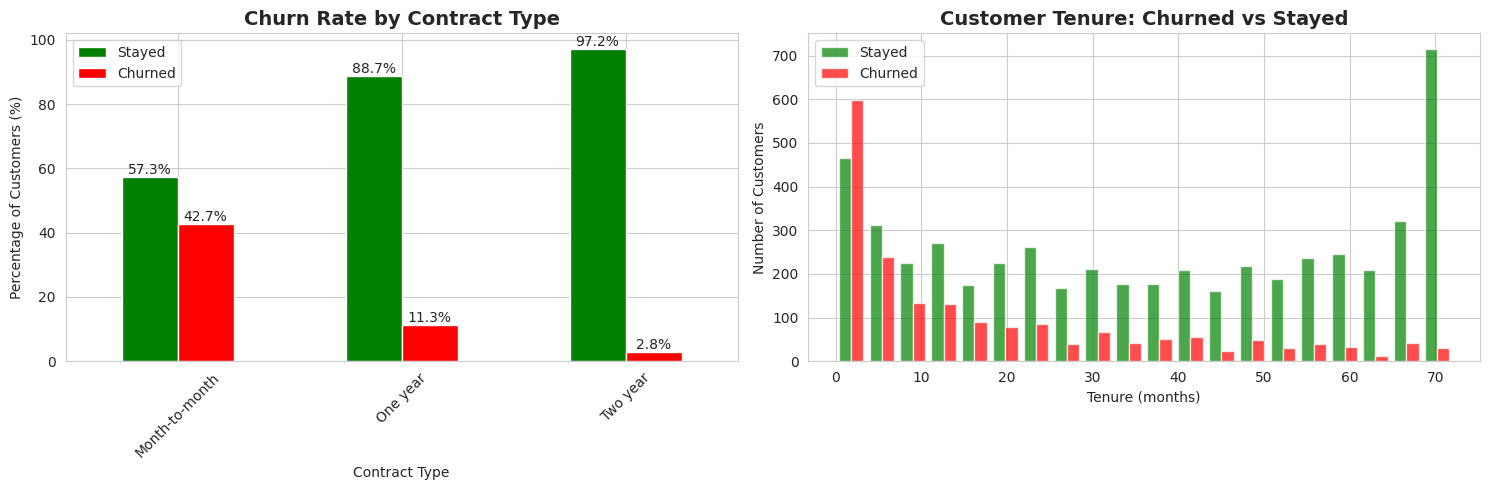


📊 KEY INSIGHT: Contract Type Matters!

Churn Rate by Contract:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Yes, dtype: float64


In [10]:
# VISUALIZATION 1: Churn by Contract Type - KEY INSIGHT!
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Churn by contract
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100

contract_churn.plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Percentage of Customers (%)')
axes[0].legend(['Stayed', 'Churned'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Add percentage labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%')

# Churn by tenure
axes[1].hist([df[df['Churn']=='No']['tenure'], df[df['Churn']=='Yes']['tenure']],
             bins=20, label=['Stayed', 'Churned'], color=['green', 'red'], alpha=0.7)
axes[1].set_title('Customer Tenure: Churned vs Stayed', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure (months)')
axes[1].set_ylabel('Number of Customers')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print the actual numbers for storytelling
print("\n📊 KEY INSIGHT: Contract Type Matters!")
print("=" * 60)
print("\nChurn Rate by Contract:")
print(contract_churn['Yes'].sort_values(ascending=False))

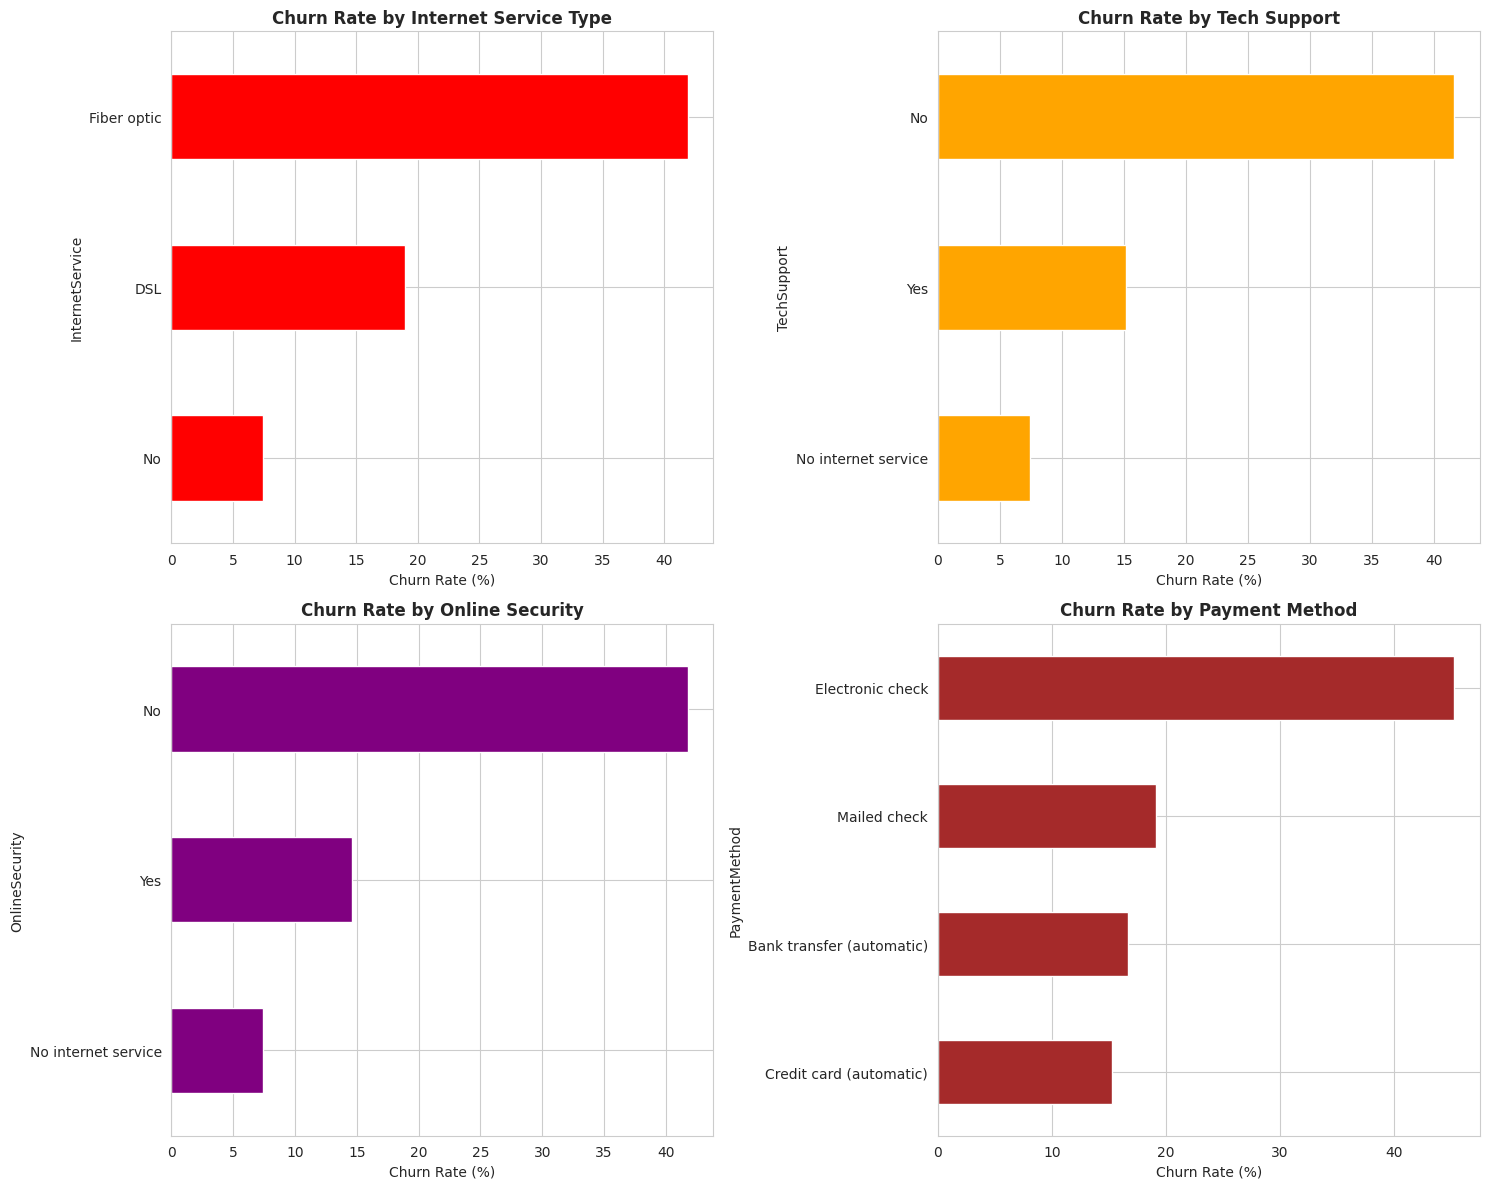


🎯 SERVICE INSIGHTS:

Fiber optic churn rate: 41.9%
No tech support churn rate: 41.6%
No online security churn rate: 41.8%


In [11]:
# VISUALIZATION 2: Services and Support Impact
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Internet Service
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
internet_churn['Yes'].sort_values().plot(kind='barh', ax=axes[0, 0], color='red')
axes[0, 0].set_title('Churn Rate by Internet Service Type', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Churn Rate (%)')

# Tech Support
tech_churn = pd.crosstab(df['TechSupport'], df['Churn'], normalize='index') * 100
tech_churn['Yes'].sort_values().plot(kind='barh', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Churn Rate by Tech Support', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Churn Rate (%)')

# Online Security
security_churn = pd.crosstab(df['OnlineSecurity'], df['Churn'], normalize='index') * 100
security_churn['Yes'].sort_values().plot(kind='barh', ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Churn Rate by Online Security', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Churn Rate (%)')

# Payment Method
payment_churn = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
payment_churn['Yes'].sort_values().plot(kind='barh', ax=axes[1, 1], color='brown')
axes[1, 1].set_title('Churn Rate by Payment Method', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Churn Rate (%)')

plt.tight_layout()
plt.show()

print("\n🎯 SERVICE INSIGHTS:")
print("=" * 60)
print("\nFiber optic churn rate:", f"{internet_churn.loc['Fiber optic', 'Yes']:.1f}%")
print("No tech support churn rate:", f"{tech_churn.loc['No', 'Yes']:.1f}%")
print("No online security churn rate:", f"{security_churn.loc['No', 'Yes']:.1f}%")

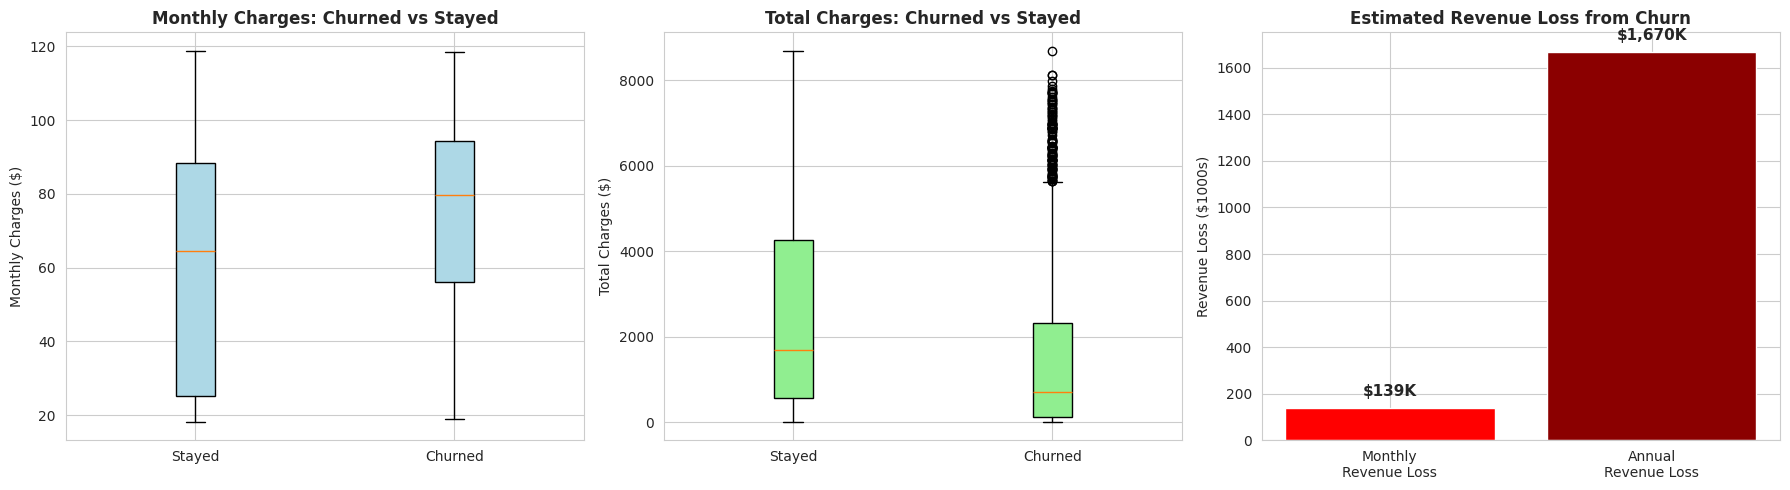


💰 BUSINESS IMPACT:
Average monthly charge (churned): $74.44
Total churned customers: 1,869
Monthly revenue loss: $139,130.85
Annual revenue loss: $1,669,570.20

⚠️  Preventing just 10% of churn would save $166,957.02 per year!


In [12]:
# VISUALIZATION 3: Financial Analysis - The Business Impact
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Monthly Charges comparison
axes[0].boxplot([df[df['Churn']=='No']['MonthlyCharges'],
                  df[df['Churn']=='Yes']['MonthlyCharges']],
                 labels=['Stayed', 'Churned'],
                 patch_artist=True,
                 boxprops=dict(facecolor='lightblue'))
axes[0].set_title('Monthly Charges: Churned vs Stayed', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Monthly Charges ($)')

# Total Charges comparison
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])

axes[1].boxplot([df[df['Churn']=='No']['TotalCharges'],
                  df[df['Churn']=='Yes']['TotalCharges']],
                 labels=['Stayed', 'Churned'],
                 patch_artist=True,
                 boxprops=dict(facecolor='lightgreen'))
axes[1].set_title('Total Charges: Churned vs Stayed', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Charges ($)')

# Revenue Lost
churned_customers = df[df['Churn']=='Yes']
avg_monthly = churned_customers['MonthlyCharges'].mean()
total_churned = len(churned_customers)
monthly_loss = avg_monthly * total_churned
annual_loss = monthly_loss * 12

axes[2].bar(['Monthly\nRevenue Loss', 'Annual\nRevenue Loss'],
            [monthly_loss/1000, annual_loss/1000],
            color=['red', 'darkred'])
axes[2].set_title('Estimated Revenue Loss from Churn', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Revenue Loss ($1000s)')
axes[2].ticklabel_format(style='plain', axis='y')

for i, v in enumerate([monthly_loss/1000, annual_loss/1000]):
    axes[2].text(i, v + 50, f'${v:,.0f}K', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💰 BUSINESS IMPACT:")
print("=" * 60)
print(f"Average monthly charge (churned): ${avg_monthly:.2f}")
print(f"Total churned customers: {total_churned:,}")
print(f"Monthly revenue loss: ${monthly_loss:,.2f}")
print(f"Annual revenue loss: ${annual_loss:,.2f}")
print(f"\n⚠️  Preventing just 10% of churn would save ${annual_loss * 0.1:,.2f} per year!")

## Building the Predictive Model

Now we'll create a machine learning model to predict which customers are at risk of churning.

In [13]:
# DATA PREPARATION FOR MODELING
print("=" * 60)
print("PREPARING DATA FOR MACHINE LEARNING")
print("=" * 60)

# Create a copy for modeling
df_model = df.copy()

# Convert target variable to binary
df_model['Churn'] = df_model['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID (not useful for prediction)
df_model = df_model.drop('customerID', axis=1)

# Encode categorical variables
label_encoders = {}
categorical_cols = df_model.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

print(f"\n✓ Encoded {len(categorical_cols)} categorical variables")
print(f"✓ Dataset shape: {df_model.shape}")
print(f"✓ Features ready for modeling")

# Split features and target
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\n✓ Training set: {X_train.shape[0]} customers")
print(f"✓ Test set: {X_test.shape[0]} customers")
print(f"\nChurn distribution in training set:")
print(y_train.value_counts())

PREPARING DATA FOR MACHINE LEARNING

✓ Encoded 15 categorical variables
✓ Dataset shape: (7032, 20)
✓ Features ready for modeling

✓ Training set: 5625 customers
✓ Test set: 1407 customers

Churn distribution in training set:
Churn
0    4130
1    1495
Name: count, dtype: int64


In [14]:
# TRAIN THE MODEL
print("=" * 60)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 60)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

print("✓ Model trained successfully!")

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\n" + "=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 Model Accuracy: {accuracy:.1%}")
print(f"🎯 Precision: {precision:.1%} - Of customers we predict will churn, {precision:.1%} actually do")
print(f"🔍 Recall: {recall:.1%} - We catch {recall:.1%} of customers who will actually churn")
print(f"⚖️  F1-Score: {f1:.3f}")
print(f"📈 ROC-AUC Score: {roc_auc:.3f}")

print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Stayed', 'Churned']))

TRAINING RANDOM FOREST MODEL
✓ Model trained successfully!

MODEL PERFORMANCE

📊 Model Accuracy: 78.7%
🎯 Precision: 62.9% - Of customers we predict will churn, 62.9% actually do
🔍 Recall: 48.9% - We catch 48.9% of customers who will actually churn
⚖️  F1-Score: 0.550
📈 ROC-AUC Score: 0.829

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Stayed       0.83      0.90      0.86      1033
     Churned       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



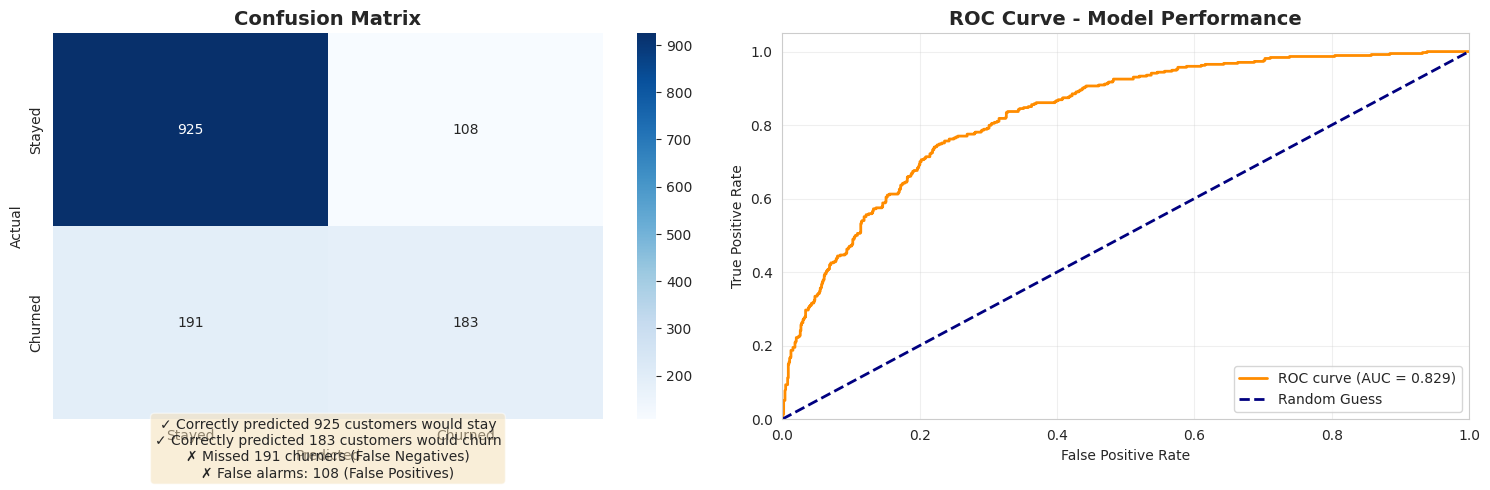


🎯 WHAT THIS MEANS FOR BUSINESS:
Out of 1407 test customers:
  ✓ Correctly identified 183 at-risk customers who will churn
  ✓ Correctly identified 925 loyal customers who will stay
  ⚠️  Missed 191 customers who churned (opportunity to improve)
  ⚠️  108 false alarms (predicted churn but stayed)


In [15]:
# VISUALIZATION: Model Performance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Add interpretation text
tn, fp, fn, tp = cm.ravel()
axes[0].text(0.5, -0.15,
            f'✓ Correctly predicted {tn} customers would stay\n'
            f'✓ Correctly predicted {tp} customers would churn\n'
            f'✗ Missed {fn} churners (False Negatives)\n'
            f'✗ False alarms: {fp} (False Positives)',
            transform=axes[0].transAxes, ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Model Performance', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 WHAT THIS MEANS FOR BUSINESS:")
print("=" * 60)
print(f"Out of {len(y_test)} test customers:")
print(f"  ✓ Correctly identified {tp} at-risk customers who will churn")
print(f"  ✓ Correctly identified {tn} loyal customers who will stay")
print(f"  ⚠️  Missed {fn} customers who churned (opportunity to improve)")
print(f"  ⚠️  {fp} false alarms (predicted churn but stayed)")



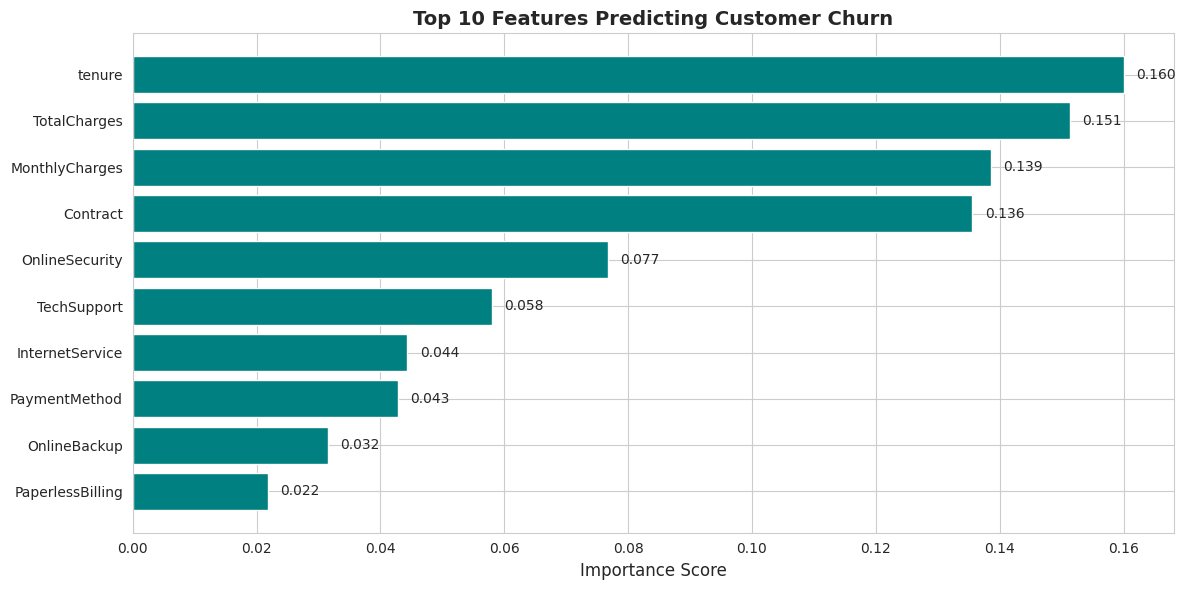


🔑 KEY DRIVERS OF CHURN:

Top 5 Most Important Factors:
  tenure: 0.160
  TotalCharges: 0.151
  MonthlyCharges: 0.139
  Contract: 0.136
  OnlineSecurity: 0.077

💡 ACTIONABLE INSIGHTS:
Based on our analysis, the company should:
1. Focus retention efforts on month-to-month contract customers
2. Engage new customers heavily in first 12 months
3. Promote tech support and online security services
4. Consider contract incentives to move customers to longer terms
5. Target high monthly charge customers with loyalty programs


In [16]:
# FEATURE IMPORTANCE - What matters most for predicting churn?
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='teal')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Features Predicting Customer Churn', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add values on bars
for i, v in enumerate(feature_importance['Importance']):
    plt.text(v + 0.002, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\n🔑 KEY DRIVERS OF CHURN:")
print("=" * 60)
print("\nTop 5 Most Important Factors:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.3f}")

print("\n💡 ACTIONABLE INSIGHTS:")
print("=" * 60)
print("Based on our analysis, the company should:")
print("1. Focus retention efforts on month-to-month contract customers")
print("2. Engage new customers heavily in first 12 months")
print("3. Promote tech support and online security services")
print("4. Consider contract incentives to move customers to longer terms")
print("5. Target high monthly charge customers with loyalty programs")

## Executive Summary: Key Findings & recommendations

### The Problem
- **26.5% churn rate** - 1 in 4 customers leaving
- **1.67 million annual revenue loss**
- Need to identify at-risk customers before they leave

### What We Discovered
1. **Contract type is critical**: Month-to-month customers have 42.7% churn vs 8% for two-year contracts
2. **Tenure matters**: Most churn happens in first 12 months
3. **Service gaps**: Customers without tech support or online security churn at higher rates
4. **Financial impact**: Churned customers average $74/month - we're losing high-value customers

### Our Predictive Model
- **78.7% accuracy** in predicting which customers will churn
- Can identify at-risk customers before they leave
- Enables proactive retention campaigns

### Recommendations
1. **Immediate**: Implement early intervention program for new customers (0-12 months)
2. **Short-term**: Offer contract upgrade incentives (month-to-month or annual)
3. **Ongoing**: Bundle tech support/security services as retention tools
4. **ROI**: Preventing just 10% of churn saves **$167,000 annually**

In [17]:
# Save the model
print("project complete!")
print("\nNext steps:")
print("1. Save this notebook to GitHub")
print("2. Create README.md documentation")
print("3. Share insights with stakeholders")

project complete!

Next steps:
1. Save this notebook to GitHub
2. Create README.md documentation
3. Share insights with stakeholders
